In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import scipy
import pickle
from scipy.interpolate import griddata
import pandas as pd
import ast
from PIL import Image
from itertools import product, combinations
from neuralpredictors.measures.np_functions import corr
from scipy.interpolate import make_interp_spline, BSpline
import warnings
warnings.filterwarnings("ignore")

import utils

In [2]:
def get_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

In [3]:
datasets = ["pretrain_21067-10-18", "pretrain_23343-5-17", "pretrain_22846-10-16",
            "pretrain_23656-14-22", "pretrain_23964-4-22"]
data_keys = [key.split("_")[1] for key in datasets]

In [4]:
cell_motor_coord = {}
for dataset in datasets:
    data_key = dataset.split("_")[1]
    cell_motor_coord[data_key] = np.load(f"./dataset/{dataset}/meta/neurons/cell_motor_coordinates.npy")

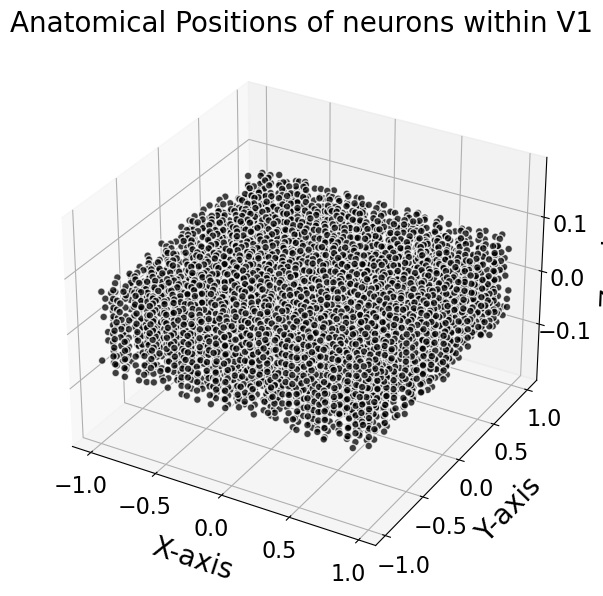

In [5]:
fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(projection='3d')

data = cell_motor_coord[data_key]
data = data - data.mean(axis=0, keepdims=True)
data = data / np.abs(data).max()  
ax.scatter(data[:, 0], 
            data[:, 1],
            data[:, 2],
            c='k', edgecolor="w", alpha=.75, 
            s=30,)
ax.set_zlim(-0.2, 0.2)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_zticks([-0.1, 0, 0.1])
ax.set_zlabel("\nZ-axis", fontsize=20)
ax.tick_params(labelsize=16)
sns.despine(trim=True)
plt.title("Anatomical Positions of neurons within V1", fontsize=20)
plt.xlabel('\nX-axis', fontsize=20)
plt.ylabel('\nY-axis', fontsize=20)
plt.tight_layout()

# plt.savefig("Figure 5/neuron_pos.png", dpi=300)

In [6]:
# np.unique(cell_motor_coord["22846-10-16"][:, 2])

In [7]:
# about 5 minutes running

def custom_agg(series):
    array = np.array([ast.literal_eval(x) for x in series])
    array = np.mean(array, axis=0)
    return array.tolist()

preds_gt = {}
for data_key in data_keys:
    pred = pd.read_csv(f"./for_paper/curBest_onchannel_noEnsemble/preds_gt/{data_key}/submission_file_live_test.csv")
    gt = pd.read_csv(f"./for_paper/curBest_onchannel_noEnsemble/preds_gt/{data_key}/ground_truth_file_test.csv")
    pred = pd.merge(pred, gt, how="left", on=["trial_indices", "image_ids", "neuron_ids"])
    preds_gt[data_key] = pred
    
for data_key in data_keys:
    preds_gt[data_key] = preds_gt[data_key].groupby("image_ids")\
        .agg({"prediction": custom_agg, 
              "responses": custom_agg,
              "neuron_ids": custom_agg})
    preds_gt[data_key].reset_index(inplace=True)
    
    mean_responses = np.vstack(preds_gt[data_key].responses)
    mean_predictions = np.vstack(preds_gt[data_key].prediction)
    correlation = corr(mean_responses, mean_predictions, axis=1)
    preds_gt[data_key]["correlation"] = correlation

In [8]:
neuron_pos_preds = {}
for data_key in data_keys:
    data = cell_motor_coord[data_key]
    data = data - data.mean(axis=0, keepdims=True)
    data = data / np.abs(data).max()
    distances = [get_distance(cur_pos, data[0]) for cur_pos in data]
    
    preds = np.array([x for x in preds_gt[data_key].prediction]).T
    image_ids = preds_gt[data_key].image_ids.tolist()
    preds_df = pd.DataFrame(np.concatenate([data, preds], axis=1), columns=["X", "Y", "Z"]+image_ids)
    preds_df["dataset"] = data_key
    preds_df["distance"] = distances
    neuron_pos_preds[data_key] = preds_df.sort_values(by="distance")
    
neuron_pos_gts = {}
for data_key in data_keys:
    data = cell_motor_coord[data_key]
    data = data - data.mean(axis=0, keepdims=True)
    data = data / np.abs(data).max()
    distances = [get_distance(cur_pos, data[0]) for cur_pos in data]
    
    gts = np.array([x for x in preds_gt[data_key].responses]).T
    image_ids = preds_gt[data_key].image_ids.tolist()
    gts_df = pd.DataFrame(np.concatenate([data, gts], axis=1), columns=["X", "Y", "Z"]+image_ids)
    gts_df["dataset"] = data_key
    gts_df["distance"] = distances
    neuron_pos_gts[data_key] = gts_df.sort_values(by="distance")

In [9]:
merged_pos_preds = neuron_pos_preds[data_keys[0]]
for data_key in data_keys[1:]:
    merged_pos_preds = pd.concat([merged_pos_preds, neuron_pos_preds[data_key]])

merged_pos_gts = neuron_pos_gts[data_keys[0]]
for data_key in data_keys[1:]:
    merged_pos_gts = pd.concat([merged_pos_gts, neuron_pos_gts[data_key]])

In [ ]:
X_bins = pd.cut(merged_pos_preds.X, bins=25).apply(lambda x: (x.left + x.right) / 2)
Y_bins = pd.cut(merged_pos_preds.Y, bins=25).apply(lambda x: (x.left + x.right) / 2)
Z_bins = pd.cut(merged_pos_preds.Z, bins=10).apply(lambda x: (x.left + x.right) / 2)

target_coords = np.array(list(product(X_bins.unique().tolist(), Y_bins.unique().tolist(), Z_bins.unique().tolist())))
grids25_keepNaN = utils.get_grids(merged_pos_preds, target_coords, data_keys, image_ids)
grids25_keepNaN_gt = utils.get_grids(merged_pos_gts, target_coords, data_keys, image_ids)

In [10]:
# with open("grids_interpolation.pkl", "wb") as f:
#     pickle.dump(grids25_keepNaN, f)
# with open("grids_interpolation_gt.pkl", "wb") as f:
#     pickle.dump(grids25_keepNaN_gt, f)

# for quick generation
grids25_keepNaN = pickle.load(open("grids_interpolation.pkl", "rb"))
grids25_keepNaN_gt = pickle.load(open("grids_interpolation_gt.pkl", "rb"))

### Neuron correlations on predictions

In [11]:
## neuron correlation
# correlations of neurons in the similar location when predicting the 100 images
preds = {}
for data_key in data_keys:
    array = grids25_keepNaN[data_key][image_ids[0]]
    
    for image_id in image_ids[1:]:
        array = np.concatenate([array, grids25_keepNaN[data_key][image_id][:, 3:4]], axis=1)
    
    array[:, :3] = np.round(array[:, :3], 4)
    preds[data_key] = array

In [12]:
corr_matrix = {}
for keys_pair in combinations(data_keys, 2):
    test1 = preds[keys_pair[0]]
    test1 = test1[~np.isnan(test1).any(axis=1)]
    
    coords = test1[:, :3]
    distances = [get_distance(coord, coords[0]) for coord in coords]
    test1 = pd.DataFrame(test1[np.argsort(distances)])

    test2 = preds[keys_pair[1]]
    test2 = test2[~np.isnan(test2).any(axis=1)]
    
    coords = test2[:, :3]
    distances = [get_distance(coord, coords[0]) for coord in coords]
    test2 = pd.DataFrame(test2[np.argsort(distances)])

    test = pd.merge(test1, test2, how="inner", on=[0, 1, 2]).iloc[:, 3:]
    n = test.shape[0]
    corr_matrix[keys_pair] = np.corrcoef(test.iloc[:, :100], test.iloc[:, 100:])[n:, :n]


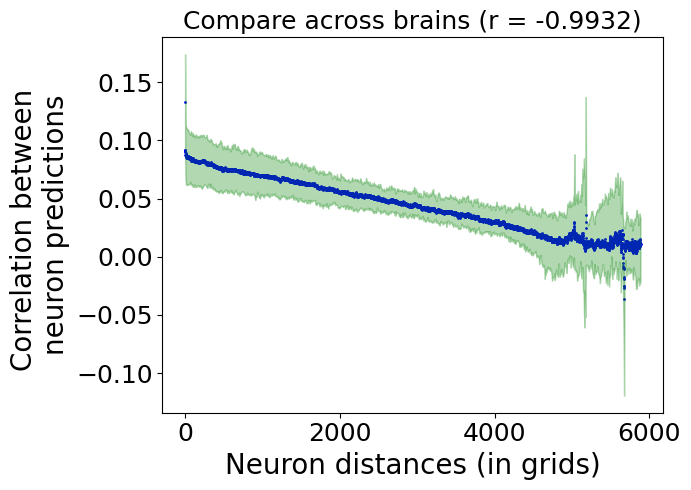

In [13]:
f, ax = utils.plot_average_neuron_corr_distance(corr_matrix, figsize=(7, 5), remove=300,
                                          xlabel="Neuron distances (in grids)",
                                          ylabel="Correlation between \nneuron predictions",
                                          title="Compare across brains")
f.tight_layout()
# f.savefig("./Figure 5/grid_corrs_summary_crossbrain_avg.png", dpi=300)

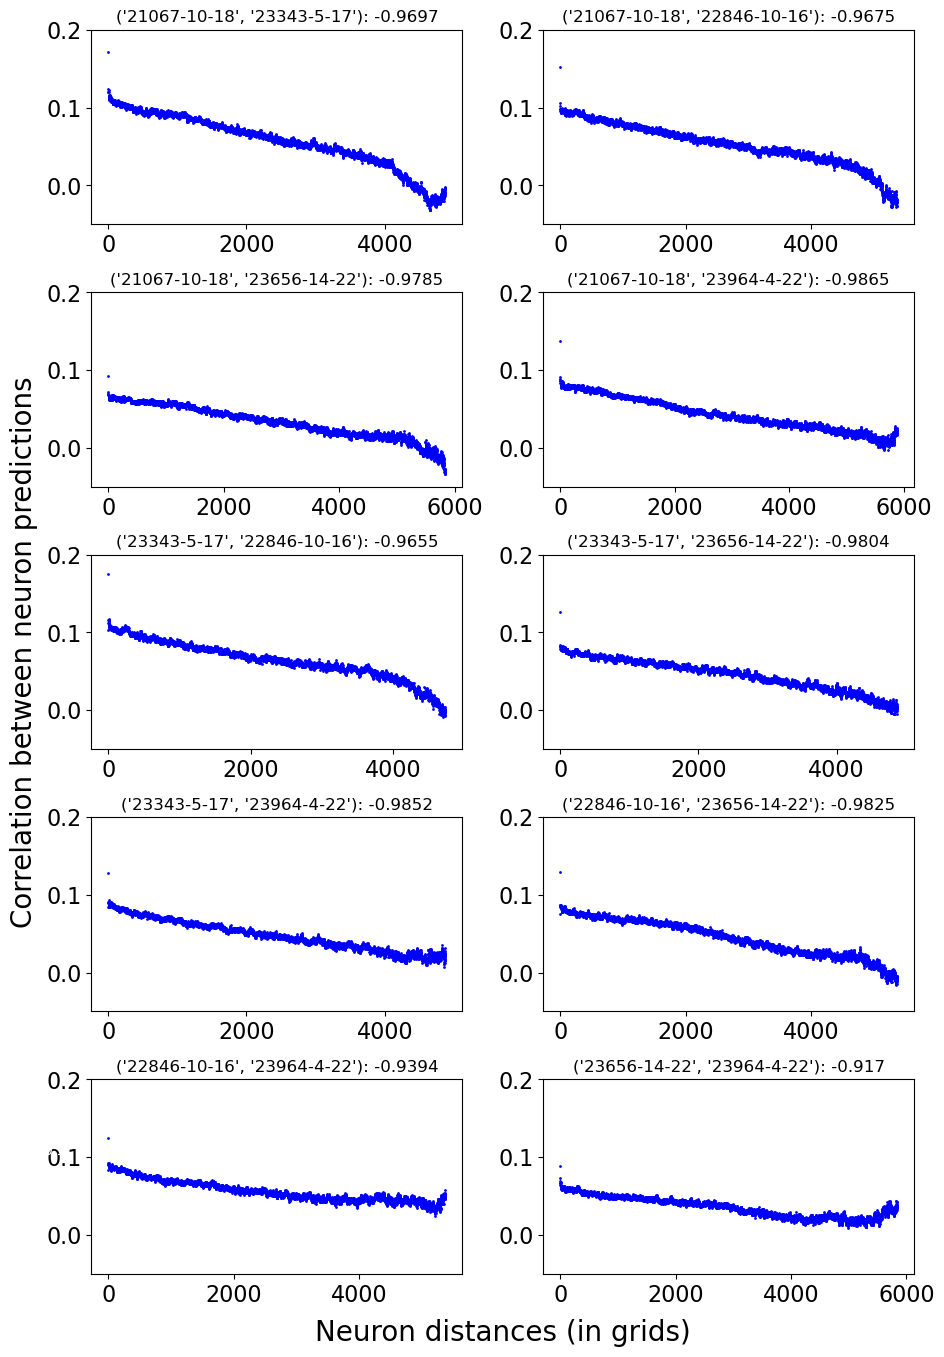

In [ ]:
f, ax = utils.plot_neuron_corr_distance(corr_matrix, figsize=(10, 14), remove=300, nrow=5, ncol=2,
                                  xlabel="Neuron distances (in grids)", 
                                  ylabel="Correlation between neuron predictions",
                                  ylim=(-0.05, 0.2))
f.tight_layout()
# f.savefig("./Figure 5/grid_corrs_summary_crossbrain.png", dpi=300)

In [14]:
corr_matrix = {}
for data_key in data_keys:
    test = preds[data_key]
    test = test[~np.isnan(test).any(axis=1)]
    
    # sort distance
    coords = test[:, :3]
    distances = [get_distance(coord, coords[0]) for coord in coords]
    test = test[np.argsort(distances), 3:]
    
    corr_matrix[data_key] = np.corrcoef(test)

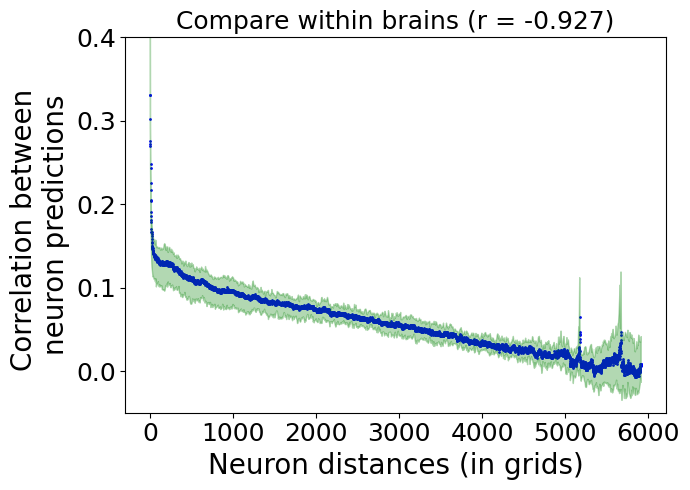

In [15]:
f, ax = utils.plot_average_neuron_corr_distance(corr_matrix, figsize=(7, 5), remove=300,
                                                xlabel="Neuron distances (in grids)",
                                                ylabel="Correlation between \nneuron predictions",
                                                title="Compare within brains", 
                                                ylim=(-0.05, 0.4))
f.tight_layout()
# f.savefig("./Figure 5/grid_corrs_summary_avg.png", dpi=300)

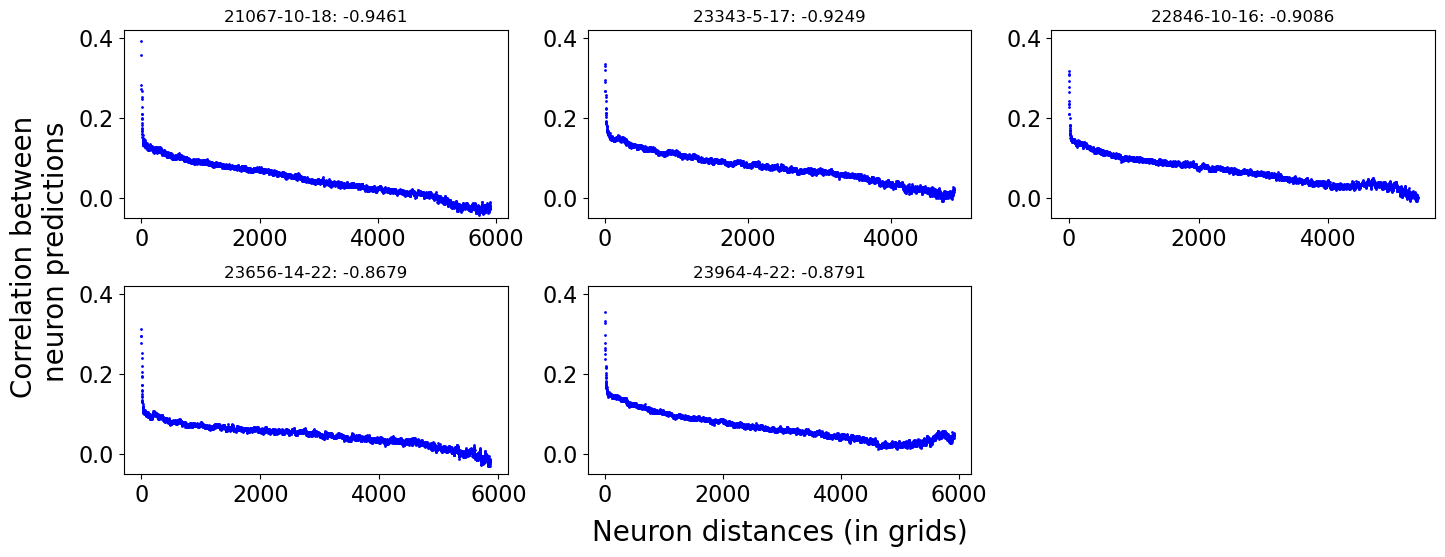

In [17]:
f, ax = utils.plot_neuron_corr_distance(corr_matrix, figsize=(15, 6), remove=300,
                                        nrow=2, ncol=3, xlabel="Neuron distances (in grids)",
                                        ylabel="Correlation between \nneuron predictions",
                                        ylim=(-0.05, 0.42))

ax[1][2].axis("off")
f.tight_layout()

# f.savefig("Figure 5/grid_corrs_summary.png", dpi=300, transparent=True)

In [ ]:
all_x = np.round(np.unique(preds["21067-10-18"][:, 0]), 4)
all_y = np.round(np.unique(preds["21067-10-18"][:, 1]), 4)
all_z = np.round(np.unique(preds["21067-10-18"][:, 2]), 4)

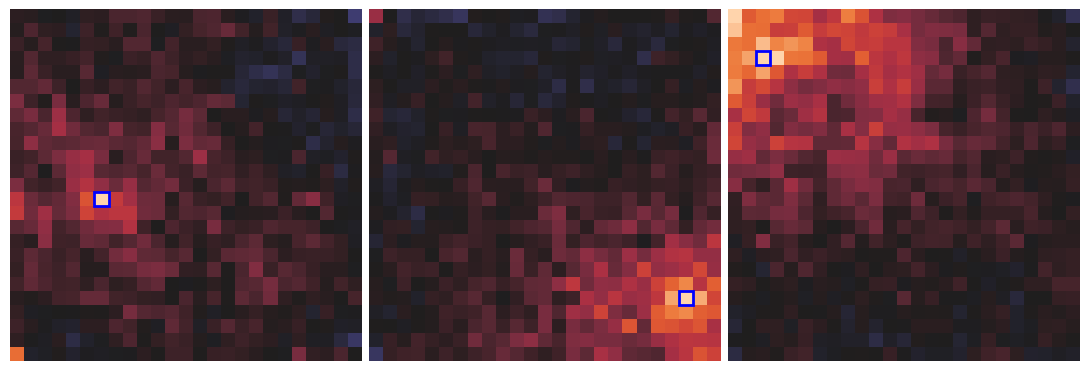

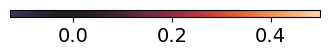

In [16]:
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
fig, axs = plt.subplots(ncols=3, figsize=(11, 4))

sns.heatmap(utils.get_corrs_alongZ(preds, data_keys, -0.48, 0.08), vmax=0.5, center=0, square=True,
            cbar=False, ax=axs[0])
axs[0].add_patch(patches.Rectangle((6, 13), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[0].set(xticklabels=[], yticklabels=[])
axs[0].tick_params(bottom=False, left=False)
axs[0].axis("off")

sns.heatmap(utils.get_corrs_alongZ(preds, data_keys, 0.8, 0.64), vmax=0.5, center=0, square=True,
            cbar=False, ax=axs[1])
axs[1].add_patch(patches.Rectangle((22, 20), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[1].set(xticklabels=[], yticklabels=[])
axs[1].tick_params(bottom=False, left=False)
axs[1].set_ylabel(None)
axs[1].axis("off")

sns.heatmap(utils.get_corrs_alongZ(preds, data_keys, -0.8, -0.72), vmax=0.5, center=0, square=True,
            cbar=False, ax=axs[2])
axs[2].add_patch(patches.Rectangle((2, 3), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[2].set(xticklabels=[], yticklabels=[])
axs[2].tick_params(bottom=False, left=False)
axs[2].set_ylabel(None)
axs[2].axis("off")

fig.tight_layout()
fig.subplots_adjust(wspace=0.02, hspace=0)

# fig.savefig("Figure 5/grid_corrs_XY.png", dpi=300, transparent=True)

cbar_fig, cbar_ax = plt.subplots(1, 1, figsize=(4, 0.1))
cbar_fig.colorbar(axs[1].collections[0], cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=14)
cbar_fig.tight_layout()
# cbar_fig.savefig("Figure 5/colorbar.png", dpi=300)

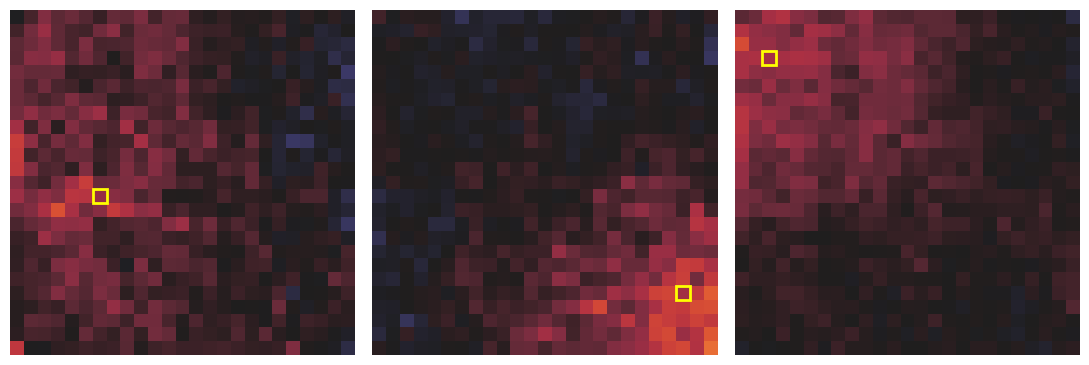

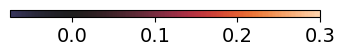

In [17]:
fig, axs = plt.subplots(ncols=3, figsize=(11, 4))

sns.heatmap(utils.get_corrs_alongZ_cross_brain(preds, data_keys, -0.48, 0.08), vmax=0.3, center=0, square=True,
            cbar=False, ax=axs[0])
axs[0].add_patch(patches.Rectangle((6, 13), 1, 1, lw=2, edgecolor='yellow', fill=False))
axs[0].set(xticklabels=[], yticklabels=[])
axs[0].tick_params(bottom=False, left=False)
axs[0].axis("off")

sns.heatmap(utils.get_corrs_alongZ_cross_brain(preds, data_keys, 0.8, 0.64), vmax=0.3, center=0, square=True,
            cbar=False, ax=axs[1])
axs[1].add_patch(patches.Rectangle((22, 20), 1, 1, lw=2, edgecolor='yellow', fill=False))
axs[1].set(xticklabels=[], yticklabels=[])
axs[1].tick_params(bottom=False, left=False)
axs[1].set_ylabel(None)
axs[1].axis("off")

sns.heatmap(utils.get_corrs_alongZ_cross_brain(preds, data_keys, -0.8, -0.72), vmax=0.5, center=0, square=True,
            cbar=False, ax=axs[2])
axs[2].add_patch(patches.Rectangle((2, 3), 1, 1, lw=2, edgecolor='yellow', fill=False))
axs[2].set(xticklabels=[], yticklabels=[])
axs[2].tick_params(bottom=False, left=False)
axs[2].set_ylabel(None)
axs[2].axis("off")

fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0)

# fig.savefig("Figure 5/grid_corrs_XY_crossbrain.png", dpi=300, transparent=True)

cbar_fig, cbar_ax = plt.subplots(1, 1, figsize=(4, 0.1))
cbar_fig.colorbar(axs[1].collections[0], cax=cbar_ax, orientation='horizontal')
cbar_ax.tick_params(labelsize=14)
cbar_fig.tight_layout()
# cbar_fig.savefig("Figure 5/colorbar_crossbrain.png", dpi=300)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 4))

sns.heatmap(utils.get_corrs_alongX(preds, data_keys, -0.48, -0.0514), vmax=0.5, center=0, square=True,
            cbar=False, ax=axs[0])
axs[0].add_patch(patches.Rectangle((6, 1), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[0].axis("off")

sns.heatmap(utils.get_corrs_alongX(preds, data_keys, 0.8, 0.0506), vmax=0.5, center=0, square=True,
            cbar=False, ax=axs[1])
axs[1].add_patch(patches.Rectangle((22, 8), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[1].set(xticklabels=[], yticklabels=[])
axs[1].axis("off")

fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0)
# fig.savefig("Figure 5/grid_corrs_YZ.png", dpi=300, transparent=True)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 4))

sns.heatmap(utils.get_corrs_alongX_cross_brain(preds, data_keys, -0.48, -0.0514), vmax=0.3, center=0, square=True,
            cbar=False, ax=axs[0])
axs[0].add_patch(patches.Rectangle((6, 1), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[0].axis("off")

sns.heatmap(utils.get_corrs_alongX_cross_brain(preds, data_keys, 0.8, 0.0506), vmax=0.3, center=0, square=True,
            cbar=False, ax=axs[1])
axs[1].add_patch(patches.Rectangle((22, 8), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[1].set(xticklabels=[], yticklabels=[])
axs[1].axis("off")

fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0)
# fig.savefig("Figure 5/grid_corrs_YZ_crossbrain.png", dpi=300, transparent=True)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 4))

sns.heatmap(utils.get_corrs_alongY(preds, data_keys, -0.72, -0.0514), vmax=0.5, center=0, square=True,
            cbar=False, ax=axs[0])
axs[0].add_patch(patches.Rectangle((3, 1), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[0].axis("off")

sns.heatmap(utils.get_corrs_alongY(preds, data_keys, 0.32, 0.0506), vmax=0.5, center=0, square=True,
            cbar=False, ax=axs[1])
axs[1].add_patch(patches.Rectangle((16, 8), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[1].set(xticklabels=[], yticklabels=[])
axs[1].axis("off")

fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0)
# fig.savefig("Figure 5/grid_corrs_XZ.png", dpi=300, transparent=True)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 4))

sns.heatmap(utils.get_corrs_alongY_cross_brain(preds, data_keys, -0.72, -0.0514), vmax=0.3, center=0, square=True,
            cbar=False, ax=axs[0])
axs[0].add_patch(patches.Rectangle((3, 1), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[0].axis("off")

sns.heatmap(utils.get_corrs_alongY_cross_brain(preds, data_keys, 0.32, 0.0506), vmax=0.3, center=0, square=True,
            cbar=False, ax=axs[1])
axs[1].add_patch(patches.Rectangle((16, 8), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[1].set(xticklabels=[], yticklabels=[])
axs[1].axis("off")

fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0)
# fig.savefig("Figure 5/grid_corrs_XZ_crossbrain.png", dpi=300, transparent=True)

In [ ]:
# may take about 15 minutes for running

ratio_z = []
ratio_y = []
ratio_x = []
# np.random.seed(1000)

for y in all_y:
    for z in all_z:
        df = utils.get_corrs_alongX(preds, data_keys, y, z)
        change_on_z = (np.abs(df[y] - df.loc[z, y]) / np.abs(df.index - z)).values
        ratio_z += change_on_z[~np.isnan(change_on_z)].tolist()
        change_on_y = np.abs(df.loc[z] - df.loc[z, y]) / np.abs(df.columns - y)
        change_on_y = change_on_y[(change_on_y.index >= (y - 0.16)) & (change_on_y.index <= (y + 0.16))]
        ratio_y += change_on_y[~np.isnan(change_on_y)].tolist()
        
for x in all_x:
    for z in all_z:
        df = utils.get_corrs_alongY(preds, data_keys, x, z)
        change_on_z = (np.abs(df[x] - df.loc[z, x]) / np.abs(df.index - z)).values
        ratio_z += change_on_z[~np.isnan(change_on_z)].tolist()
        change_on_x = np.abs(df.loc[z] - df.loc[z, x]) / np.abs(df.columns - x)
        change_on_x = change_on_x[(change_on_x.index >= (x - 0.16)) & (change_on_x.index <= (x + 0.16))]
        ratio_x += change_on_x[~np.isnan(change_on_x)].tolist()
        

In [ ]:
data = [np.array(ratio_x), np.array(ratio_y), np.array(ratio_z)]
fig, ax = plt.subplots(1, 1, figsize=(5, 6))
ax.boxplot(data, notch=True)
ax.set_xticklabels(["X-axis", "Y-axis", "Z-axis"])
# ax.set_xlabel("Correlation change on", fontsize=20)
ax.set_ylabel("Correlation change ratios", fontsize=20)
ax.tick_params(labelsize=16)
fig.tight_layout()
# fig.savefig("./Figure 5/corr_change_ratio.png", dpi=300)

In [ ]:
from scipy.stats import ttest_ind
ttest_ind(np.array(ratio_y), np.array(ratio_z), equal_var=True)

### Neuron correlations in responses

In [ ]:
preds = {}
for data_key in data_keys:
    array = grids25_keepNaN_gt[data_key][image_ids[0]]
    
    for image_id in image_ids[1:]:
        array = np.concatenate([array, grids25_keepNaN_gt[data_key][image_id][:, 3:4]], axis=1)
    
    array[:, :3] = np.round(array[:, :3], 4)
    preds[data_key] = array


corr_matrix = {}
for keys_pair in combinations(data_keys, 2):
    test1 = preds[keys_pair[0]]
    test1 = test1[~np.isnan(test1).any(axis=1)]
    
    coords = test1[:, :3]
    distances = [get_distance(coord, coords[0]) for coord in coords]
    test1 = pd.DataFrame(test1[np.argsort(distances)])

    test2 = preds[keys_pair[1]]
    test2 = test2[~np.isnan(test2).any(axis=1)]
    
    coords = test2[:, :3]
    distances = [get_distance(coord, coords[0]) for coord in coords]
    test2 = pd.DataFrame(test2[np.argsort(distances)])

    test = pd.merge(test1, test2, how="inner", on=[0, 1, 2]).iloc[:, 3:]
    n = test.shape[0]
    corr_matrix[keys_pair] = np.corrcoef(test.iloc[:, :100], test.iloc[:, 100:])[n:, :n]

In [ ]:
f, ax = utils.plot_average_neuron_corr_distance(corr_matrix, figsize=(7, 5), remove=300,
                                                xlabel="Neuron distances (in grids)",
                                                ylabel="Correlation between \nneuron responses",
                                                title="Compare across brains",
                                                ylim=(-0.07, 0.2))

f.tight_layout()
f.savefig("./Figure 5/grid_corrs_summary_crossbrain_gt_avg.png", dpi=300)

In [ ]:
f, ax = utils.plot_neuron_corr_distance(corr_matrix, figsize=(10, 14), nrow=5, ncol=2, remove=300,
                                        xlabel="Neuron distances (in grids)", 
                                        ylabel="Correlation between neuron responses",
                                        ylim=(-0.05, 0.2))
f.tight_layout()
# f.savefig("./Figure 5/grid_corrs_summary_crossbrain_gt.png", dpi=300)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 4))

sns.heatmap(utils.get_corrs_alongZ_cross_brain(preds, data_keys, -0.48, 0.08), vmax=0.2, center=0, square=True,
            cbar=False, ax=axs[0])
axs[0].add_patch(patches.Rectangle((6, 13), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[0].set(xticklabels=[], yticklabels=[])
axs[0].tick_params(bottom=False, left=False)
axs[0].axis("off")

sns.heatmap(utils.get_corrs_alongZ_cross_brain(preds, data_keys, 0.8, 0.64), vmax=0.2, center=0, square=True,
            cbar=False, ax=axs[1])
axs[1].add_patch(patches.Rectangle((22, 20), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[1].set(xticklabels=[], yticklabels=[])
axs[1].tick_params(bottom=False, left=False)
axs[1].set_ylabel(None)
axs[1].axis("off")

fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0)

# fig.savefig("Figure 5/grid_corrs_XY_crossbrain_gt.png", dpi=300, transparent=True)

cbar_fig, cbar_ax = plt.subplots(1, 1, figsize=(0.1, 6))
cbar_fig.colorbar(axs[1].collections[0], cax=cbar_ax)
cbar_fig.tight_layout()
# cbar_fig.savefig("Figure 5/colorbar_crossbrain_gt.png", dpi=300)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 4))

sns.heatmap(utils.get_corrs_alongX_cross_brain(preds, data_keys, -0.48, -0.0514), vmax=0.2, center=0, square=True,
            cbar=False, ax=axs[0])
axs[0].add_patch(patches.Rectangle((6, 1), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[0].axis("off")

sns.heatmap(utils.get_corrs_alongX_cross_brain(preds, data_keys, 0.8, 0.0506), vmax=0.2, center=0, square=True,
            cbar=False, ax=axs[1])
axs[1].add_patch(patches.Rectangle((22, 8), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[1].set(xticklabels=[], yticklabels=[])
axs[1].axis("off")

fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0)
# fig.savefig("Figure 5/grid_corrs_YZ_crossbrain_gt.png", dpi=300, transparent=True)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 4))

sns.heatmap(utils.get_corrs_alongY_cross_brain(preds, data_keys, -0.72, -0.0514), vmax=0.2, center=0, square=True,
            cbar=False, ax=axs[0])
axs[0].add_patch(patches.Rectangle((3, 1), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[0].axis("off")

sns.heatmap(utils.get_corrs_alongY_cross_brain(preds, data_keys, 0.32, 0.0506), vmax=0.2, center=0, square=True,
            cbar=False, ax=axs[1])
axs[1].add_patch(patches.Rectangle((16, 8), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[1].set(xticklabels=[], yticklabels=[])
axs[1].axis("off")

fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0)
# fig.savefig("Figure 5/grid_corrs_XZ_crossbrain_gt.png", dpi=300, transparent=True)

In [ ]:
corr_matrix = {}
for data_key in data_keys:
    test = preds[data_key]
    test = test[~np.isnan(test).any(axis=1)]
    
    # sort distance
    coords = test[:, :3]
    distances = [get_distance(coord, coords[0]) for coord in coords]
    test = test[np.argsort(distances), 3:]
    
    corr_matrix[data_key] = np.corrcoef(test)

In [ ]:
f, ax = utils.plot_average_neuron_corr_distance(corr_matrix, figsize=(7, 5), remove=300,
                                                xlabel="Neuron distances (in grids)",
                                                ylabel="Correlation between \nneuron responses",
                                                title="Compare within brains",
                                                ylim=(-0.1, 0.4))

f.tight_layout()
# f.savefig("./Figure 5/grid_corrs_summary_gt_avg.png", dpi=300)

In [ ]:
f, ax = utils.plot_neuron_corr_distance(corr_matrix, figsize=(15, 6), nrow=2, ncol=3, remove=300,
                                        xlabel="Neuron distances (in grids)", 
                                        ylabel="Correlation between neuron responses",
                                        ylim=(-0.1, 0.4))

ax[1][2].axis("off")
f.tight_layout()

# f.savefig("Figure 5/grid_corrs_summary_gt.png", dpi=300, transparent=True)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 4))

sns.heatmap(utils.get_corrs_alongZ(preds, data_keys, -0.48, 0.08), vmax=0.5, center=0, square=True,
            cbar=False, ax=axs[0])
axs[0].add_patch(patches.Rectangle((6, 13), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[0].set(xticklabels=[], yticklabels=[])
axs[0].tick_params(bottom=False, left=False)
axs[0].axis("off")

sns.heatmap(utils.get_corrs_alongZ(preds, data_keys, 0.8, 0.64), vmax=0.5, center=0, square=True,
            cbar=False, ax=axs[1])
axs[1].add_patch(patches.Rectangle((22, 20), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[1].set(xticklabels=[], yticklabels=[])
axs[1].tick_params(bottom=False, left=False)
axs[1].set_ylabel(None)
axs[1].axis("off")

fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0)

# fig.savefig("Figure 5/grid_corrs_XY_gt.png", dpi=300, transparent=True)

cbar_fig, cbar_ax = plt.subplots(1, 1, figsize=(0.1, 6))
cbar_fig.colorbar(axs[1].collections[0], cax=cbar_ax)
cbar_fig.tight_layout()
# cbar_fig.savefig("Figure 5/colorbar_gt.png", dpi=300)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 4))

sns.heatmap(utils.get_corrs_alongX(preds, data_keys, -0.48, -0.0514), vmax=0.5, center=0, square=True,
            cbar=False, ax=axs[0])
axs[0].add_patch(patches.Rectangle((6, 1), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[0].axis("off")

sns.heatmap(utils.get_corrs_alongX(preds, data_keys, 0.8, 0.0506), vmax=0.5, center=0, square=True,
            cbar=False, ax=axs[1])
axs[1].add_patch(patches.Rectangle((22, 8), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[1].set(xticklabels=[], yticklabels=[])
axs[1].axis("off")

fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0)
# fig.savefig("Figure 5/grid_corrs_YZ_gt.png", dpi=300, transparent=True)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(6, 4))

sns.heatmap(utils.get_corrs_alongY(preds, data_keys, -0.72, -0.0514), vmax=0.5, center=0, square=True,
            cbar=False, ax=axs[0])
axs[0].add_patch(patches.Rectangle((3, 1), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[0].axis("off")

sns.heatmap(utils.get_corrs_alongY(preds, data_keys, 0.32, 0.0506), vmax=0.5, center=0, square=True,
            cbar=False, ax=axs[1])
axs[1].add_patch(patches.Rectangle((16, 8), 1, 1, lw=2, edgecolor='blue', fill=False))
axs[1].set(xticklabels=[], yticklabels=[])
axs[1].axis("off")

fig.tight_layout()
fig.subplots_adjust(wspace=0.05, hspace=0)
# fig.savefig("Figure 5/grid_corrs_XZ_gt.png", dpi=300, transparent=True)

In [ ]:
ratio_z_gt = []
ratio_y_gt = []
ratio_x_gt = []
# np.random.seed(1000)

for y in all_y:
    for z in all_z:
        df = utils.get_corrs_alongX(preds, data_keys, y, z)
        change_on_z = (np.abs(df[y] - 1) / np.abs(df.index - z)).values
        ratio_z_gt += change_on_z[~np.isnan(change_on_z)].tolist()
        change_on_y = np.abs(df.loc[z] - 1) / np.abs(df.columns - y)
        change_on_y = change_on_y[(change_on_y.index >= (y - 0.16)) & (change_on_y.index <= (y + 0.16))]
        ratio_y_gt += change_on_y[~np.isnan(change_on_y)].tolist()
        
for x in all_x:
    for z in all_z:
        df = utils.get_corrs_alongY(preds, data_keys, x, z)
        change_on_z = (np.abs(df[x] - 1) / np.abs(df.index - z)).values
        ratio_z_gt += change_on_z[~np.isnan(change_on_z)].tolist()
        change_on_x = np.abs(df.loc[z] - 1) / np.abs(df.columns - x)
        change_on_x = change_on_x[(change_on_x.index >= (x - 0.16)) & (change_on_x.index <= (x + 0.16))]
        ratio_x_gt += change_on_x[~np.isnan(change_on_x)].tolist()

In [ ]:
data = [np.array(ratio_x_gt), np.array(ratio_y_gt), np.array(ratio_z_gt)]
fig, ax = plt.subplots(1, 1, figsize=(5, 6))
ax.boxplot(data, notch=True)
ax.set_xticklabels(["X-axis", "Y-axis", "Z-axis"])
# ax.set_xlabel("Correlation change on", fontsize=20)
ax.set_ylabel("Correlation change ratios", fontsize=20)
ax.tick_params(labelsize=16)
fig.tight_layout()
# fig.savefig("./Figure 5/corr_change_ratio_gt.png", dpi=300)

In [ ]:
from scipy.stats import ttest_ind
ttest_ind(np.array(ratio_y_gt), np.array(ratio_z_gt), equal_var=False)